In [3]:
import pandas as pd

In [4]:
jobs = pd.read_csv('../data/fullsample.csv')
jobs.head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0
1,30853133,COMPLETED,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06T19:04:39,2021-09-05T19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09T16:52:51,2021-09-07T20:52:55,65536Mn,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17T07:45:07,2021-09-10T16:45:24,16384Mn,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0


In [5]:
jobs.info

<bound method DataFrame.info of               JOBID      STATE                BEGIN                  END  \
0          30616928    RUNNING  2021-07-31T22:15:00              Unknown   
1          30853133  COMPLETED  2021-08-06T11:36:09  2021-09-05T11:36:32   
2          30858137  COMPLETED  2021-08-06T19:04:39  2021-09-05T19:04:53   
3          30935078  COMPLETED  2021-08-09T16:52:51  2021-09-07T20:52:55   
4        31364111_2  COMPLETED  2021-08-17T07:45:07  2021-09-10T16:45:24   
...             ...        ...                  ...                  ...   
7395880    25493434  COMPLETED  2020-10-31T23:39:00  2020-10-31T23:40:46   
7395881    25493435  COMPLETED  2020-10-31T23:39:13  2020-10-31T23:40:38   
7395882    25493476  COMPLETED  2020-10-31T23:46:29  2020-10-31T23:49:43   
7395883    25493515  COMPLETED  2020-10-31T23:49:44  2020-10-31T23:51:40   
7395884    25493542  COMPLETED  2020-10-31T23:56:49  2020-10-31T23:59:57   

           REQMEM    USEDMEM      REQTIME     USEDTIME 

In [6]:
jobs.columns

Index(['JOBID', 'STATE', 'BEGIN', 'END', 'REQMEM', 'USEDMEM', 'REQTIME',
       'USEDTIME', 'NODES', 'CPUS', 'PARTITION', 'EXITCODE'],
      dtype='object')

In [7]:
incomplete_jobs = jobs[(jobs['EXITCODE']!='0:0') | (jobs['STATE']!='COMPLETED')]
incomplete_jobs.head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0
18,31418105,NODE_FAIL,2021-08-19T10:09:50,2021-09-17T08:45:10,92160Mn,0,41-16:00:00,28-22:35:20,1,8,cgw-dougherty1,1:0
42,31669402,CANCELLED,2021-08-28T10:53:59,2021-09-05T10:53:57,65536Mn,5229.75M,8-00:00:00,7-23:59:58,9,10,production,0:15
1023,31798622,CANCELLED,2021-08-31T02:46:09,2021-09-05T02:46:09,40960Mn,1440.95M,5-00:00:00,5-00:00:00,4,4,turing,0:15
1029,31798672,CANCELLED,2021-08-31T02:53:48,2021-09-05T02:54:09,40960Mn,1438.46M,5-00:00:00,5-00:00:21,4,4,turing,0:15


In [8]:
incomplete_jobs['STATE'].value_counts()

STATE
CANCELLED              9055
FAILED                 3766
CANCELLED by 9201      1776
OUT_OF_MEMORY          1739
CANCELLED by 776869     702
                       ... 
CANCELLED by 686562       1
CANCELLED by 891323       1
CANCELLED by 19853        1
CANCELLED by 494371       1
CANCELLED by 515423       1
Name: count, Length: 144, dtype: int64

In [9]:
ce5 = pd.read_csv('../data/slurm_wrapper_ce5.log',
                  header=None,
                  delimiter=' - ',
                  engine='python',
                 )

ce5.head()

,0,1,2,3,4,5
0,2020-10-16 08:15:39.278699,user 0,retry 0,time 0.07347559928894043,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
1,2020-10-16 08:18:08.313309,user 0,retry 0,time 0.18363237380981445,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
2,2020-10-16 08:22:48.128689,user 0,retry 0,time 0.07547116279602051,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
3,2020-10-16 08:25:13.257408,user 0,retry 0,time 0.09484362602233887,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
4,2020-10-16 08:31:01.460723,user 0,retry 0,time 0.07498788833618164,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."


To identify periods of unresponsiveness, use the two log files. Look for records that are the "sbatch" command from user 9204 (the test user) that have return code 1 and an execution time of greater than 15 seconds.

In [10]:
ce5[['test', 'response_time']] = ce5[3].str.split(' ', n=1, expand=True)
ce5 = ce5.drop([3, 'test'], axis=1)
ce5

,0,1,2,4,5,response_time
0,2020-10-16 08:15:39.278699,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.07347559928894043
1,2020-10-16 08:18:08.313309,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.18363237380981445
2,2020-10-16 08:22:48.128689,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.07547116279602051
3,2020-10-16 08:25:13.257408,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.09484362602233887
4,2020-10-16 08:31:01.460723,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.07498788833618164
...,...,...,...,...,...,...
4770888,2021-10-07 21:58:06.738329,user 9203,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.02677178382873535
4770889,2021-10-07 21:58:15.931559,user 9201,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.04166150093078613
4770890,2021-10-07 21:58:48.900136,user 9221,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.14348959922790527
4770891,2021-10-07 21:59:11.314056,user 9203,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.026599407196044922


In [11]:
ce5['response_time'] = ce5['response_time'].astype(float)
ce5

,0,1,2,4,5,response_time
0,2020-10-16 08:15:39.278699,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.073476
1,2020-10-16 08:18:08.313309,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.183632
2,2020-10-16 08:22:48.128689,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.075471
3,2020-10-16 08:25:13.257408,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.094844
4,2020-10-16 08:31:01.460723,user 0,retry 0,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '...",0.074988
...,...,...,...,...,...,...
4770888,2021-10-07 21:58:06.738329,user 9203,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.026772
4770889,2021-10-07 21:58:15.931559,user 9201,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.041662
4770890,2021-10-07 21:58:48.900136,user 9221,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.143490
4770891,2021-10-07 21:59:11.314056,user 9203,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.026599


In [12]:
ce5_unresponsive = ce5[(ce5[5].str.contains('sbatch')) & (ce5[4].str.contains('returncode 1'))]
ce5_unresponsive

,0,1,2,4,5,response_time
3465,2020-10-16 11:43:45.753267,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.150959
3466,2020-10-16 11:43:45.920205,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.218138
3467,2020-10-16 11:43:45.939591,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.188296
3468,2020-10-16 11:43:46.119672,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.114305
3469,2020-10-16 11:43:46.380161,user 9202,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.092560
...,...,...,...,...,...,...
4661384,2021-09-24 19:13:14.894282,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.051321
4661728,2021-09-24 20:16:31.458641,user 9221,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.044075
4726331,2021-10-02 08:14:16.557499,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",19.083227
4730667,2021-10-02 17:28:16.726151,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.026319


In [13]:
ce5_unresponsive = ce5_unresponsive[ce5_unresponsive['response_time']>=15]
ce5_unresponsive

,0,1,2,4,5,response_time
3465,2020-10-16 11:43:45.753267,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.150959
3466,2020-10-16 11:43:45.920205,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.218138
3467,2020-10-16 11:43:45.939591,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.188296
3468,2020-10-16 11:43:46.119672,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.114305
3469,2020-10-16 11:43:46.380161,user 9202,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.092560
...,...,...,...,...,...,...
4661384,2021-09-24 19:13:14.894282,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.051321
4661728,2021-09-24 20:16:31.458641,user 9221,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.044075
4726331,2021-10-02 08:14:16.557499,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",19.083227
4730667,2021-10-02 17:28:16.726151,user 9201,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.026319


In [14]:
ce5_unresponsive[1].value_counts()

1
user 9201    38358
user 9219     7082
user 9202     5949
user 9203     3433
user 9221     1984
user 9204     1811
Name: count, dtype: int64

In [15]:
ce5_unresponsive_9204 = ce5_unresponsive[ce5_unresponsive[1].str.contains('user 9204')]

In [16]:
ce5_unresponsive_9204['response_time'].describe()

count    1811.000000
mean       20.451334
std         2.705505
min        19.025584
25%        20.033827
50%        20.040414
75%        20.047409
max        43.075887
Name: response_time, dtype: float64

In [17]:
ce5_unresponsive_9204.head(5)

,0,1,2,4,5,response_time
49958,2020-10-18 06:53:44.272915,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.038464
49972,2020-10-18 06:54:04.322412,user 9204,retry 1,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.048906
50467,2020-10-18 07:47:25.825172,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.082628
50473,2020-10-18 07:47:45.871008,user 9204,retry 1,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.045221
50582,2020-10-18 07:53:33.972840,user 9204,retry 0,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",20.041486


# CE6

In [18]:
ce6 = pd.read_csv('../data/slurm_wrapper_ce6.log',
                  header=None,
                  delimiter=' - ',
                  engine='python',
                 )

ce6.head()

,0,1,2,3,4,5
0,2020-10-16 10:37:44.163454,user 9202,retry 0,time 0.08495402336120605,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
1,2020-10-16 10:37:44.206654,user 9202,retry 0,time 0.08943057060241699,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
2,2020-10-16 10:37:44.218760,user 9202,retry 0,time 0.05928945541381836,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
3,2020-10-16 10:37:44.256403,user 9202,retry 0,time 0.038695573806762695,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
4,2020-10-16 10:37:44.611603,user 9202,retry 0,time 0.03343677520751953,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."


In [19]:
ce6[['test', 'response_time']] = ce6[3].str.split(' ', n=1, expand=True)
ce6 = ce6.drop([3, 'test'], axis=1)
ce6['response_time'] = ce6['response_time'].astype(float)
ce6

,0,1,2,4,5,response_time
0,2020-10-16 10:37:44.163454,user 9202,retry 0,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.084954
1,2020-10-16 10:37:44.206654,user 9202,retry 0,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.089431
2,2020-10-16 10:37:44.218760,user 9202,retry 0,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.059289
3,2020-10-16 10:37:44.256403,user 9202,retry 0,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.038696
4,2020-10-16 10:37:44.611603,user 9202,retry 0,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.033437
...,...,...,...,...,...,...
4776515,2021-10-07 21:59:35.014602,user 9221,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.060087
4776516,2021-10-07 21:59:35.238970,user 9202,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.098044
4776517,2021-10-07 21:59:57.265189,user 9203,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.024550
4776518,2021-10-07 22:00:04.024360,user 9201,retry 0,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.039419


In [20]:
ce6_test = ce6

In [21]:
ce6_test['return_code'] = ce6_test[4].str.split(' ', expand=True)[1]
ce6_test = ce6_test.drop([4], axis=1)
ce6_test

,0,1,2,5,response_time,return_code
0,2020-10-16 10:37:44.163454,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.084954,0
1,2020-10-16 10:37:44.206654,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.089431,0
2,2020-10-16 10:37:44.218760,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.059289,0
3,2020-10-16 10:37:44.256403,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.038696,0
4,2020-10-16 10:37:44.611603,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.033437,0
...,...,...,...,...,...,...
4776515,2021-10-07 21:59:35.014602,user 9221,retry 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.060087,0
4776516,2021-10-07 21:59:35.238970,user 9202,retry 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.098044,0
4776517,2021-10-07 21:59:57.265189,user 9203,retry 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.024550,0
4776518,2021-10-07 22:00:04.024360,user 9201,retry 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u...",0.039419,0


In [30]:
from datetime import datetime

date_string = ce6_test[0].iloc[0]

def try_parsing_date(text):
    for fmt in ("%Y-%m-%d %H:%M:%S.%f", "%Y-%m-%d %H:%M:%S"):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found')

date = try_parsing_date(date_string)
print(date)

2020-10-16 10:37:44.163454


In [31]:
ce6_test['datetime'] = ce6_test[0].apply(lambda x: try_parsing_date(x))
ce6_test.head()

,0,1,2,5,response_time,return_code,datetime
0,2020-10-16 10:37:44.163454,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.084954,0,2020-10-16 10:37:44.163454
1,2020-10-16 10:37:44.206654,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.089431,0,2020-10-16 10:37:44.206654
2,2020-10-16 10:37:44.218760,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.059289,0,2020-10-16 10:37:44.218760
3,2020-10-16 10:37:44.256403,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.038696,0,2020-10-16 10:37:44.256403
4,2020-10-16 10:37:44.611603,user 9202,retry 0,"command ['/usr/bin/scontrol', 'show', 'job', '...",0.033437,0,2020-10-16 10:37:44.611603


In [33]:
from matplotlib import pyplot as plt
import seaborn as sns

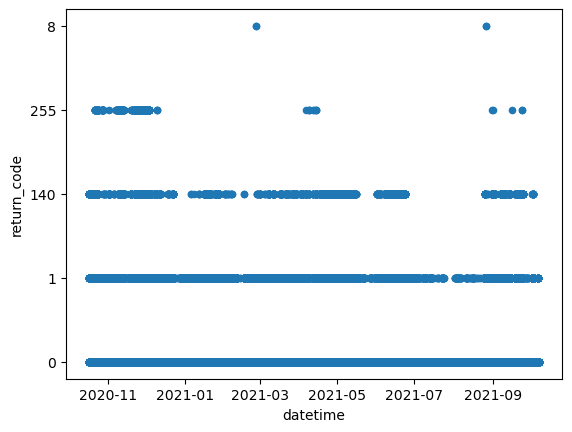

In [ ]:
ce6_test.plot(x='datetime', y='return_code', kind='scatter');

KeyboardInterrupt: 

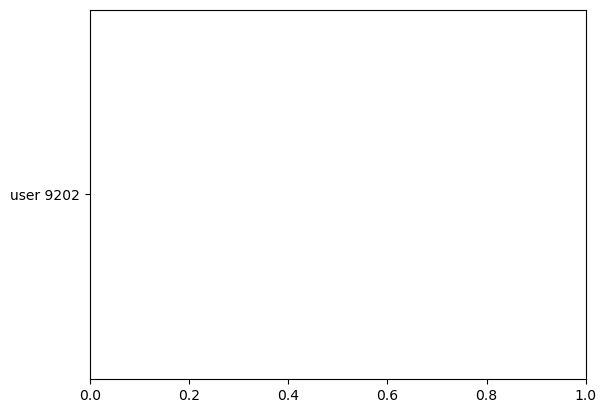

In [34]:
sns.countplot(ce6_test, x='datetime');

In [ ]:
ce6_unresponsive = ce6[(ce6[5].str.contains('sbatch')) & (ce6[4].str.contains('returncode 1'))]
ce6_unresponsive = ce6_unresponsive[ce6_unresponsive['response_time']>=15]

In [ ]:
ce6_unresponsive[1].value_counts()

1
user 9201    31282
user 9202     5974
user 9219     5276
user 9203     2722
user 9221     2014
user 9204     1485
Name: count, dtype: int64

In [ ]:
ce6_unresponsive_9204 = ce6_unresponsive[ce6_unresponsive[1].str.contains('user 9204')]

In [ ]:
ce6_unresponsive_9204['response_time'].describe()

count    1485.000000
mean       20.252049
std         1.828402
min        19.027786
25%        20.032605
50%        20.039831
75%        20.045578
max        43.078285
Name: response_time, dtype: float64